In [1]:
import numpy as np
import torch
import pandas as pd
import torchvision
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F
from torch.autograd import Variable
from tqdm.notebook import tqdm
from typing import Optional

/home/sasha/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:

class Classifier(nn.Module): 
    def __init__(self, classes: int = 10): 
        super().__init__() 
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1) 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) 
        self.pool = nn.MaxPool2d(2, 2) 
        #self.dropout1 = nn.Dropout2d(0.25) 
        #self.dropout2 = nn.Dropout2d(0.5) 
        self.fc1 = nn.Linear(64 * 7 * 7, 128) 
        self.fc2 = nn.Linear(128, classes) 
  
    def forward(self, x): 
        x = self.pool(F.relu(self.conv1(x))) 
        #x = self.dropout1(x) 
        x = self.pool(F.relu(self.conv2(x))) 
        #x = self.dropout2(x) 
        x = x.view(-1, 64 * 7 * 7) 
        x = F.relu(self.fc1(x)) 
        x = self.fc2(x) 
        return x

In [3]:
from src.methods.bayes.variational.net import BayesVarLogNormModule, VarBayesModuleNet
from src.methods.bayes.variational.optimization import NormLogVarKLLoss


In [4]:
test_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
train_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

In [5]:
module = Classifier()

In [6]:
#bayes_model = BayesModule(module)
var_module = BayesVarLogNormModule(module)
bayes_model = VarBayesModuleNet(module, nn.ModuleList([var_module]))

In [7]:
print(bayes_model)

VarBayesModuleNet(
  (base_module): Classifier(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=3136, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=10, bias=True)
  )
  (module_list): ModuleList(
    (0): BayesVarLogNormModule(
      (base_module): Classifier(
        (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (fc1): Linear(in_features=3136, out_features=128, bias=True)
        (fc2): Linear(in_features=128, out_features=10, bias=True)
      )
      (posterior_params): ParameterDict(
          (param_mus): Object of type: Pa

In [8]:
cnt = 0
for i, p in enumerate(bayes_model.parameters()):
    cnt += 1
print(cnt)

48


In [9]:
a = torch.tensor([[0, 2.], [3, 0]])
b =  torch.tensor([1., 1.])
a_s = a.to_sparse()
print(a_s @ b)

tensor([2., 3.])


In [10]:
optimizer = optim.Adam(bayes_model.parameters(), lr=0.1)

In [11]:
image, label = test_dataset[10]
y = bayes_model(torch.ones_like(image))
kl_loss = NormLogVarKLLoss()

out = y.sum() + kl_loss(bayes_model.posterior_params)
optimizer.zero_grad() 
out.backward() 
optimizer.step() 

In [12]:
bayes_model.prune({'threshold': -2.2})

In [13]:
bayes_model.set_map_params()

In [14]:
bayes_model.state_dict()

OrderedDict([('base_module.conv1.weight',
              tensor([[[[ 0.1513, -0.0165,  0.0000],
                        [ 0.1779,  0.0670, -0.0116],
                        [ 0.0788,  0.0953, -0.1730]]],
              
              
                      [[[-0.0115,  0.0839, -0.0632],
                        [ 0.1947, -0.1068,  0.0000],
                        [ 0.0482,  0.0000, -0.0720]]],
              
              
                      [[[-0.0200, -0.0586, -0.1992],
                        [-0.1834,  0.0000, -0.0624],
                        [-0.0439,  0.0000,  0.0503]]],
              
              
                      [[[ 0.0235,  0.0000, -0.0000],
                        [-0.0386,  0.0108, -0.0853],
                        [ 0.0000, -0.0396, -0.2011]]],
              
              
                      [[[ 0.1152,  0.0610, -0.0000],
                        [ 0.0360, -0.0450,  0.1017],
                        [ 0.0000, -0.1582, -0.1753]]],
              
              
   

In [15]:
print(bayes_model(torch.zeros_like(image)))
#print(bayes_model(torch.zeros_like(image), sample = False))
print(module(torch.zeros_like(image)))

tensor([[-39.0373, -62.6277, -60.2015, -67.0256, -63.5926, -73.0402, -54.6278,
         -69.3109, -57.3077, -89.4715]], grad_fn=<AddmmBackward0>)
tensor([[-39.0373, -62.6277, -60.2015, -67.0256, -63.5926, -73.0402, -54.6278,
         -69.3109, -57.3077, -89.4715]], grad_fn=<AddmmBackward0>)


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
device

device(type='cuda')

In [17]:
from src.methods.bayes.variational.trainer import VarBayesTrainer, VarTrainerParams, Beta_Shelduer_Plato

In [18]:
beta = Beta_Shelduer_Plato()

In [ ]:
BATCH_SIZE=1000
EPOCHS=1000
LR = 5e-4 #5e-4
# Split the training set into training and validation sets 
VAL_PERCENT = 0.2 # percentage of the data used for validation 
SAMPLES = 10
BETA = 0.01 #5e-5
BETA_FAC = 5e-1
PRUNE = -2.1#-1.99, -2.1
PLATO_TOL = 10

base_module = Classifier()
var_module = BayesVarLogNormModule(base_module)
model = VarBayesModuleNet(base_module, nn.ModuleList([var_module]))

optimizer = optim.Adam(model.parameters(), lr=LR)

fit_loss = nn.CrossEntropyLoss() 
kl_loss = NormLogVarKLLoss()

beta = Beta_Shelduer_Plato(BETA, BETA_FAC, PLATO_TOL)
beta_KL = Beta_Shelduer_Plato(beta.beta, 1 / BETA_FAC, PLATO_TOL, ref = beta, threshold=1e-4)

model.to(device) 
train_params = VarTrainerParams(EPOCHS, optimizer,fit_loss, kl_loss, SAMPLES, BATCH_SIZE, VAL_PERCENT, PRUNE, beta, beta_KL)
trainer = VarBayesTrainer(train_params, None, train_dataset)
trainer.train(model)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [1/1000],Loss:30384.580078125, KL Loss: 3038255.25. FitLoss: 2.0282952785491943, Validation Loss:60769.15625,Accuracy:0.405,Validation Accuracy:0.603, Prune parameters: 22062.0/0, Beta: 0.01
Epoch [2/1000],Loss:30357.921875, KL Loss: 3035643.5. FitLoss: 1.4887241125106812, Validation Loss:60715.818359375,Accuracy:0.639,Validation Accuracy:0.718, Prune parameters: 22876.0/0, Beta: 0.01
Epoch [3/1000],Loss:30331.29296875, KL Loss: 3033033.25. FitLoss: 0.9607586860656738, Validation Loss:60662.55078125,Accuracy:0.771,Validation Accuracy:0.77, Prune parameters: 23748.0/0, Beta: 0.01
Epoch [4/1000],Loss:30304.890625, KL Loss: 3030424.0. FitLoss: 0.651192843914032, Validation Loss:60609.791015625,Accuracy:0.792,Validation Accuracy:0.8, Prune parameters: 24632.0/0, Beta: 0.01
Epoch [5/1000],Loss:30278.662109375, KL Loss: 3027813.5. FitLoss: 0.5276549458503723, Validation Loss:60557.349609375,Accuracy:0.843,Validation Accuracy:0.824, Prune parameters: 25485.0/0, Beta: 0.01
Epoch [6/1000]

In [ ]:
torch.save(model.state_dict(), 'model_bayes.pt' )

In [ ]:
model.prune({'threshold': -2.2})
print(model.prune_stats())

tensor(42008., device='cuda:0')


In [ ]:
model.prune([{'threshold': -2.2}])
print(model.prune_stats())

tensor(42008., device='cuda:0')


In [ ]:
module = Classifier()
var_module = BayesVarLogNormModule(module)
model_loaded = VarBayesModuleNet(module, nn.ModuleList([var_module]))

Classifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
model_loaded.state_dict()

OrderedDict([('base_module.conv1.weight',
              tensor([[[[ 0.2035, -0.2536, -0.0236],
                        [-0.0560,  0.2274, -0.0954],
                        [-0.0052,  0.0550, -0.2993]]],
              
              
                      [[[ 0.0138, -0.2355,  0.0264],
                        [-0.2964,  0.0145, -0.2705],
                        [ 0.2480,  0.2730,  0.1577]]],
              
              
                      [[[-0.0344,  0.3114, -0.1653],
                        [-0.3273, -0.1941,  0.2667],
                        [-0.2385, -0.2884, -0.2063]]],
              
              
                      [[[-0.2763,  0.1471,  0.0600],
                        [-0.0593,  0.2652, -0.2083],
                        [ 0.0383, -0.1728,  0.0017]]],
              
              
                      [[[ 0.2279, -0.0865,  0.3212],
                        [-0.1594, -0.2940, -0.1540],
                        [-0.0288,  0.0004, -0.1815]]],
              
              
   

In [ ]:
model.state_dict().keys()

odict_keys(['base_module.conv1.weight', 'base_module.conv1.bias', 'base_module.conv2.weight', 'base_module.conv2.bias', 'base_module.fc1.weight', 'base_module.fc1.bias', 'base_module.fc2.weight', 'base_module.fc2.bias', 'module_list.0.base_module.conv1.weight', 'module_list.0.base_module.conv1.bias', 'module_list.0.base_module.conv2.weight', 'module_list.0.base_module.conv2.bias', 'module_list.0.base_module.fc1.weight', 'module_list.0.base_module.fc1.bias', 'module_list.0.base_module.fc2.weight', 'module_list.0.base_module.fc2.bias', 'module_list.0.posterior_params.param_mus.0', 'module_list.0.posterior_params.param_mus.1', 'module_list.0.posterior_params.param_mus.2', 'module_list.0.posterior_params.param_mus.3', 'module_list.0.posterior_params.param_mus.4', 'module_list.0.posterior_params.param_mus.5', 'module_list.0.posterior_params.param_mus.6', 'module_list.0.posterior_params.param_mus.7', 'module_list.0.posterior_params.param_std_log.0', 'module_list.0.posterior_params.param_std_

In [ ]:
model.state_dict()

OrderedDict([('base_module.conv1.weight',
              tensor([[[[-0.1150, -0.1711, -0.2262],
                        [ 0.2571,  0.2341, -0.1276],
                        [ 0.0336,  0.0570, -0.0747]]],
              
              
                      [[[ 0.3253, -0.0823, -0.1200],
                        [ 0.0782,  0.0027,  0.2380],
                        [ 0.0468,  0.3225,  0.0179]]],
              
              
                      [[[-0.2420, -0.1251, -0.3169],
                        [-0.0599, -0.2754, -0.0174],
                        [ 0.1708,  0.2793,  0.0900]]],
              
              
                      [[[ 0.3033,  0.0390,  0.0174],
                        [-0.2891, -0.0387, -0.1865],
                        [-0.2147, -0.0049, -0.0321]]],
              
              
                      [[[ 0.0315, -0.1105, -0.2170],
                        [-0.1168,  0.1463,  0.2220],
                        [-0.1986, -0.2693,  0.1953]]],
              
              
   

In [ ]:
model_loaded.load_state_dict(model.state_dict())

<All keys matched successfully>

In [ ]:

model_loaded.load_state_dict(torch.load('model_bayes.pt'))
image1, label1 = test_dataset[10]
image2, label2 = test_dataset[11]
model_loaded(image1)

tensor([[-0.0304, -0.0969, -0.0192,  0.0014,  0.0137,  0.0437,  0.1580, -0.0035,
          0.0549,  0.0406]], grad_fn=<AddmmBackward0>)

In [ ]:
val_loss = 0.0
val_acc = 0.0
PRUNE = -2.2
test_loader = torch.utils.data.DataLoader(test_dataset,  
                                         batch_size=BATCH_SIZE,  
                                         shuffle=False, 
                                         pin_memory=True) 
kl_loss = NormLogVarKLLoss()
model.prune({'threshold': PRUNE})
model.set_map_params()
cnt_prune_parameters = model.prune_stats()
with torch.no_grad(): 
        for images, labels in test_loader: 
            labels=labels.to(device) 
            images=images.to(device) 
            fit_loss_total = 0 
            for j in range(no_samples):
                
                outputs = model(images)
                KL_loss_total = kl_loss(model.posterior_params)
                # calculate fit loss based on mean and standard deviation of output
                fit_loss_total = fit_loss_total + criterion(outputs, labels)  
            total_loss = (fit_loss_total)/(no_samples) + float(beta)* KL_loss_total
            val_loss += total_loss.item() 
              
            _, predicted = torch.max(outputs.data, 1) 
        total = labels.size(0) 
        
        correct = (predicted == labels).sum().item() 
        val_acc += correct / total 
print(f'Loss:{val_loss}, KL Loss: {KL_loss_total}, FitLoss: {fit_loss_total / no_samples}, Accuracy {val_acc}, Prune parameters: {cnt_prune_parameters}/{cnt_params}, Beta: {float(beta)}')

Loss:1824147.423828125, KL Loss: 3040015.25, FitLoss: 2.304708957672119, Accuracy 0.106, Prune parameters: 42021.0/0, Beta: 0.01


Label: 3


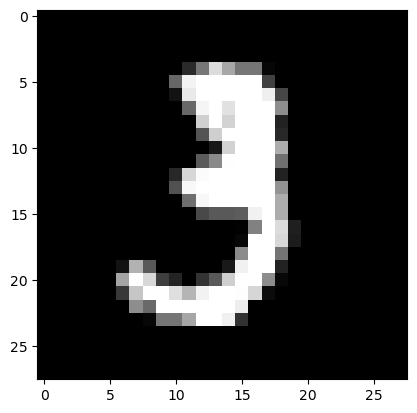

In [ ]:
image, label = test_dataset[10]
plt.imshow(image.permute(1, 2, 0), cmap = 'gray')
print('Label:', label)

In [ ]:
torch.max(model(image.cuda()).data, 1)

torch.return_types.max(
values=tensor([0.1252], device='cuda:0'),
indices=tensor([6], device='cuda:0'))